In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# --- Unzip the dataset ---
# IMPORTANT: Update this path to match the location of your zip file in Drive.
zip_path = '/content/drive/MyDrive/ColabNotebooks/Vision/inpainting/ffhq256_10ksubset.zip'

# The destination folder in the local Colab environment.
destination_path = '/content'

print("Unzipping dataset...")
# The -q flag makes the output cleaner (quiet mode)
!unzip -q {zip_path} -d {destination_path}

print(f"✅ Dataset unzipped to {destination_path}")

Unzipping dataset...
✅ Dataset unzipped to /content


In [3]:
# Install
!pip -q install pytorch_wavelets torchmetrics lpips torch-fidelity

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 57.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
import torch._dynamo
from torch.utils.data import Dataset, DataLoader, Subset
from torch.nn.utils import spectral_norm
from torchvision.utils import save_image, make_grid
from torchvision import transforms
from PIL import Image
import pandas as pd
import time
import random
import math
from tqdm.auto import tqdm
from tqdm.autonotebook import tqdm
import os
import glob
import matplotlib.pyplot as plt

import torchmetrics
from torchmetrics.image.fid import FrechetInceptionDistance
import lpips

import torch.fft
from pytorch_wavelets import DWTForward
from einops import rearrange

# Enable TensorFloat32
torch.set_float32_matmul_precision('high')

# --- Configuration & Hyperparameters ---

# Set the path to your image folder in Google Drive
# IMPORTANT: Update this path to match where you saved your dataset.
DATASET_PATH = '/content/ffhq_subset_10k'
NUM_IMAGES_TO_USE_CNN = 10000
NUM_IMAGES_TO_USE_GAN = 1000

# Training settings
NUM_EPOCHS_CNN = 40
NUM_EPOCHS_GAN = 200
LEARNING_RATE = 1e-4
BATCH_SIZE = 4

# Set the device (use GPU if available)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

Using device: cuda


In [5]:
class FFHQDataset(Dataset):
    """Custom PyTorch Dataset for loading FFHQ images."""
    def __init__(self, img_dir, transform=None, num_images=None): # Add num_images parameter
        """
        Args:
            img_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
            num_images (int, optional): Number of images to use. If None, use all images.
        """
        # Find all files with .png or .jpg extension
        self.img_paths = glob.glob(os.path.join(img_dir, '*.png'))
        self.img_paths.extend(glob.glob(os.path.join(img_dir, '*.jpg')))
        self.transform = transform

        if num_images:
            # If a number is specified, shuffle all paths and take a random subset
            random.shuffle(self.img_paths)
            self.img_paths = self.img_paths[:num_images]

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

# Your transform definition remains the same
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [6]:
def tensor_to_image(tensor):
    """
    Converts a PyTorch tensor to a displayable NumPy image.
    It denormalizes, moves to CPU, and changes dimension order.
    """
    # Denormalize the image from [-1, 1] to [0, 1]
    image = tensor * 0.5 + 0.5
    # Move tensor to CPU and convert to NumPy array
    image = image.cpu().numpy()
    # Transpose dimensions from (C, H, W) to (H, W, C) for plotting
    image = image.transpose(1, 2, 0)
    # Clip values to be in the valid [0, 1] range for images
    image = np.clip(image, 0, 1)
    return image

In [7]:
def create_mask(image, mask_percentage=0.025):
    """
    Creates masks that are more likely to cover facial features.
    """
    batch_size, _, height, width = image.shape
    mask = torch.ones_like(image)

    # Face regions typically in center 60% of image
    center_bias = 0.3  # 30% border on each side

    for i in range(batch_size):
        mask_h = int(np.sqrt(height * width * mask_percentage))
        mask_w = mask_h

        # Bias towards center
        top_min = int(height * center_bias)
        top_max = int(height * (1 - center_bias)) - mask_h
        left_min = int(width * center_bias)
        left_max = int(width * (1 - center_bias)) - mask_w

        top = np.random.randint(top_min, max(top_min + 1, top_max))
        left = np.random.randint(left_min, max(left_min + 1, left_max))

        mask[i, :, top:top+mask_h, left:left+mask_w] = 0

    masked_image = image * mask
    return masked_image, mask

In [8]:
class SelfAttention(nn.Module):
    """ A simple self-attention layer """
    def __init__(self, channels):
        super().__init__()
        self.query = nn.Conv2d(channels, channels // 8, 1)
        self.key   = nn.Conv2d(channels, channels // 8, 1)
        self.value = nn.Conv2d(channels, channels, 1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, C, width, height = x.size()
        q = self.query(x).view(batch_size, -1, width * height).permute(0, 2, 1)
        k = self.key(x).view(batch_size, -1, width * height)
        v = self.value(x).view(batch_size, -1, width * height)

        attention_map = F.softmax(torch.bmm(q, k), dim=-1)

        out = torch.bmm(v, attention_map.permute(0, 2, 1))
        out = out.view(batch_size, C, width, height)

        return self.gamma * out + x # Add skip connection

class UpsampleBlock(nn.Module):
    """An upsampling block using Conv2d and PixelShuffle."""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # The Conv2d layer produces 4x the channels for a 2x upscale
        self.conv = nn.Conv2d(in_channels, out_channels * 4, kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(2) # Rearranges channels to upscale by 2x
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.pixel_shuffle(self.conv(x)))

class GatedConv2d(nn.Module):
    """
    A Gated Convolutional Layer.
    It learns a dynamic feature mask for each channel at every location.
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1):
        super().__init__()
        # Convolution for the features
        self.conv_feature = nn.Conv2d(
            in_channels, out_channels, kernel_size, stride, padding, dilation
        )
        # Convolution for the gating mechanism
        self.conv_gate = nn.Conv2d(
            in_channels, out_channels, kernel_size, stride, padding, dilation
        )

    def forward(self, x):
        # Get the features and the gate
        features = self.conv_feature(x)
        gate = torch.sigmoid(self.conv_gate(x)) # Gate values are between 0 and 1

        # Element-wise multiplication to apply the learned gate
        return features * gate

class GatedResidualBlock(nn.Module):
    """A Residual Block that uses Gated Convolutions."""
    def __init__(self, channels, dilation=1):
        super().__init__()
        padding = dilation

        # Replace nn.Conv2d with GatedConv2d
        self.conv1 = GatedConv2d(channels, channels, kernel_size=3, padding=padding, dilation=dilation)
        self.bn1 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = GatedConv2d(channels, channels, kernel_size=3, padding=padding, dilation=dilation)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = out + residual  # Residual connection
        out = self.relu(out)
        return out

class UNetSR(nn.Module):
    """
    A U-Net architecture with corrected channel dimensions for the decoder.
    """
    def __init__(self, in_channels=4, out_channels=3, num_channels=64):
        super().__init__()

        # --- Initial Convolution ---
        self.init_conv = nn.Conv2d(in_channels, num_channels, kernel_size=3, padding=1)

        # --- Encoder Path ---
        self.enc1 = GatedResidualBlock(num_channels, dilation=1)
        self.enc2 = GatedResidualBlock(num_channels, dilation=1)
        self.pool = nn.MaxPool2d(2)

        # --- Bottleneck with Dilation and Attention ---
        self.bottleneck = nn.Sequential(
            GatedResidualBlock(num_channels, dilation=2),
            # SelfAttention(num_channels), # Add attention layer
            GatedResidualBlock(num_channels, dilation=4)
        )

        # --- Decoder Path ---
        self.upconv2 = UpsampleBlock(num_channels, num_channels)
        # Input channels = upsampled (64) + skip connection from e2 (64) = 128
        self.dec2 = GatedResidualBlock(num_channels * 2, dilation=1)

        self.upconv1 = UpsampleBlock(num_channels * 2, num_channels)
        # Input channels = upsampled (64) + skip connection from e1 (64) = 128
        self.dec1 = GatedResidualBlock(num_channels * 2, dilation=1)

        # --- Final Output Layer ---
        # The input to this layer comes from dec1, which outputs 128 channels.
        self.out_conv = nn.Conv2d(num_channels * 2, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        # Initial feature extraction
        x0 = self.init_conv(x)

        # Encoder
        e1 = self.enc1(x0)
        p1 = self.pool(e1)

        e2 = self.enc2(p1)
        p2 = self.pool(e2)

        # Bottleneck
        b = self.bottleneck(p2)

        # Decoder with Skip Connections
        d2 = self.upconv2(b)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.upconv1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        # Final Output
        out = self.out_conv(d1)

        return torch.tanh(out)

In [9]:
# --- 1. Create the main dataset ---
# This should use the LARGER number of images you intend to work with.
# Let's assume NUM_IMAGES_TO_USE_CNN is the total pool of images.
print("Creating the main dataset...")
full_dataset = FFHQDataset(
    img_dir=DATASET_PATH,
    transform=transform,
    num_images=NUM_IMAGES_TO_USE_CNN # Use the total number of images available for the experiment
)
print(f"✅ Main dataset created with {len(full_dataset)} images.")

# --- 2. Split the dataset into Training, Validation, and Test sets ---
print("\nSplitting data into training, validation, and test sets...")
dataset_size = len(full_dataset)
indices = list(range(dataset_size))
np.random.seed(42) # for reproducibility
np.random.shuffle(indices)

# Define split points for an 80/10/10 split
train_split = int(np.floor(0.8 * dataset_size))
val_split = int(np.floor(0.9 * dataset_size))

# Create indices for each set
train_indices = indices[:train_split]
val_indices = indices[train_split:val_split]
test_indices = indices[val_split:]

# Create PyTorch Subsets
train_data = Subset(full_dataset, train_indices)
val_data = Subset(full_dataset, val_indices)
test_data = Subset(full_dataset, test_indices)

print(f"✅ Training set size: {len(train_data)}")
print(f"✅ Validation set size: {len(val_data)}")
print(f"✅ Test set size: {len(test_data)}")

# --- 3. Create the Diffusion Model's training subset ---
# This should be a subset of the TRAINING data.
print("\nCreating a subset of the training data for the GAN model...")
gan_indices = train_indices[:NUM_IMAGES_TO_USE_GAN] # Take from the start of shuffled train indices
gan_data = Subset(full_dataset, gan_indices)
print(f"✅ Diffusion training set size: {len(gan_data)}")


# --- 4. Create DataLoaders for each set ---
print("\nCreating DataLoaders...")
# The main CNN will now train on the 'train_data' subset
cnn_dataloader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)
# New DataLoader for validation
val_dataloader = DataLoader(
    val_data,
    batch_size=BATCH_SIZE,
    shuffle=False, # No need to shuffle validation data
    num_workers=4,
    pin_memory=True
)
# New DataLoader for testing
test_dataloader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=False, # No need to shuffle test data
    num_workers=4,
    pin_memory=True
)
# GAN DataLoader uses its own subset of the training data
gan_dataloader = DataLoader(
    gan_data,
    batch_size=32,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    drop_last=True
)
print("✅ All DataLoaders created.")

# --- 5. Initialize models and optimizers (unchanged) ---
print("\nInitializing models and optimizers...")
cnn_model = UNetSR().to(DEVICE)

# Compile the models for a speed boost
cnn_model = torch.compile(cnn_model)

# Initialize optimizers
optimizer_cnn = optim.Adam(cnn_model.parameters(), lr=LEARNING_RATE)

print("\nSetup complete. Ready for CNN training!")

Creating the main dataset...
✅ Main dataset created with 10000 images.

Splitting data into training, validation, and test sets...
✅ Training set size: 8000
✅ Validation set size: 1000
✅ Test set size: 1000

Creating a subset of the training data for the GAN model...
✅ Diffusion training set size: 1000

Creating DataLoaders...
✅ All DataLoaders created.

Initializing models and optimizers...

Setup complete. Ready for CNN training!


In [ ]:
# --- Stage 1: Pre-train the CNN ---
print("--- Stage 1: Pre-training CNN ---")

ACCUMULATION_STEPS = 4
WARMUP_EPOCHS = 5
best_val_loss = float('inf')

# Initialize the DWT transform
dwt = DWTForward(J=1, mode='zero', wave='haar').to(DEVICE)
alpha = 0.1  # Weight for FFT Loss
beta = 0.1   # Weight for DWT Loss

# Add scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_cnn, mode='min', factor=0.5, patience=10
)

# Initialize a Gradient Scaler for the 'cuda' device
scaler = torch.amp.GradScaler('cuda')

for epoch in tqdm(range(NUM_EPOCHS_CNN), desc="CNN Epochs"):
    cnn_model.train()
    epoch_losses = []

    for i, batch in enumerate(cnn_dataloader):
        original_image = batch.to(DEVICE)
        masked_image, mask = create_mask(original_image)
        mask = mask.to(DEVICE)

        # --- Part 1: Run the main CNN in Mixed Precision for speed ---
        with torch.amp.autocast('cuda'):
            cnn_input = torch.cat((masked_image, mask[:, 0:1, :, :]), dim=1)
            coarse_inpainting = cnn_model(cnn_input)

            # --- Spatial Domain Loss (can stay in autocast) ---
            hole_mask = 1 - mask
            valid_loss = nn.functional.l1_loss(
                coarse_inpainting * mask,
                original_image * mask,
                reduction='sum'
            ) / mask.sum().clamp(min=1)

            hole_loss = 10 * nn.functional.l1_loss(
                coarse_inpainting * hole_mask,
                original_image * hole_mask,
                reduction='sum'
            ) / hole_mask.sum().clamp(min=1)

            l1_loss = valid_loss + hole_loss

        # --- Part 2: Calculate sensitive losses in Full Precision (float32) ---
        # Explicitly cast the output to float32 before FFT and DWT
        coarse_inpainting_fp32 = coarse_inpainting.float()

        if epoch < WARMUP_EPOCHS:
            loss = l1_loss
        else:
            # --- FFT Loss (in float32) ---
            fft_pred = torch.fft.fft2(coarse_inpainting_fp32, dim=(-2, -1))
            fft_gt = torch.fft.fft2(original_image, dim=(-2, -1))
            fft_loss = nn.functional.mse_loss(torch.abs(fft_pred), torch.abs(fft_gt))

            # --- DWT Loss (in float32) ---
            _, Yh_pred = dwt(coarse_inpainting_fp32)
            _, Yh_gt = dwt(original_image)
            dwt_loss = nn.functional.l1_loss(Yh_pred[0], Yh_gt[0])

            # Combine all losses. PyTorch handles the type promotion automatically.
            loss = l1_loss + alpha * fft_loss + beta * dwt_loss

        # --- Backpropagation (unchanged) ---
        loss = loss / ACCUMULATION_STEPS
        scaler.scale(loss).backward()

        if (i + 1) % ACCUMULATION_STEPS == 0:
            scaler.step(optimizer_cnn)
            scaler.update()
            optimizer_cnn.zero_grad()

        epoch_losses.append(loss.item() * ACCUMULATION_STEPS)

    avg_train_loss = np.mean(epoch_losses)
    print(f"\nEpoch {epoch}: Train Loss = {avg_train_loss:.4f}")

print("✅ CNN Pre-training Complete.")
torch.save(cnn_model.state_dict(), 'final_cnn_model.pth')

--- Evaluating CNN Model ---
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Evaluating on multiple batches...

CNN INPAINTING EVALUATION RESULTS

📊 RECONSTRUCTION METRICS:
  PSNR:  38.53 ± 1.72 dB
  SSIM:  0.9896 ± 0.0029
  MSE:   0.0002 ± 0.0001
  MAE:   0.0037 ± 0.0005

🎨 PERCEPTUAL METRICS:
  LPIPS: 0.0086 ± 0.0017 (lower is better)
  FID:   4.69 (lower is better)

🎯 MASKED REGION METRICS:
  Masked MSE: 0.0169 ± 0.0082
  Masked MAE: 0.1459 ± 0.0271

📈 FREQUENCY DOMAIN ANALYSIS:
  Average Frequency Magnitude Ratio: 0.980
  High-Frequency Recovery Ratio: 0.981


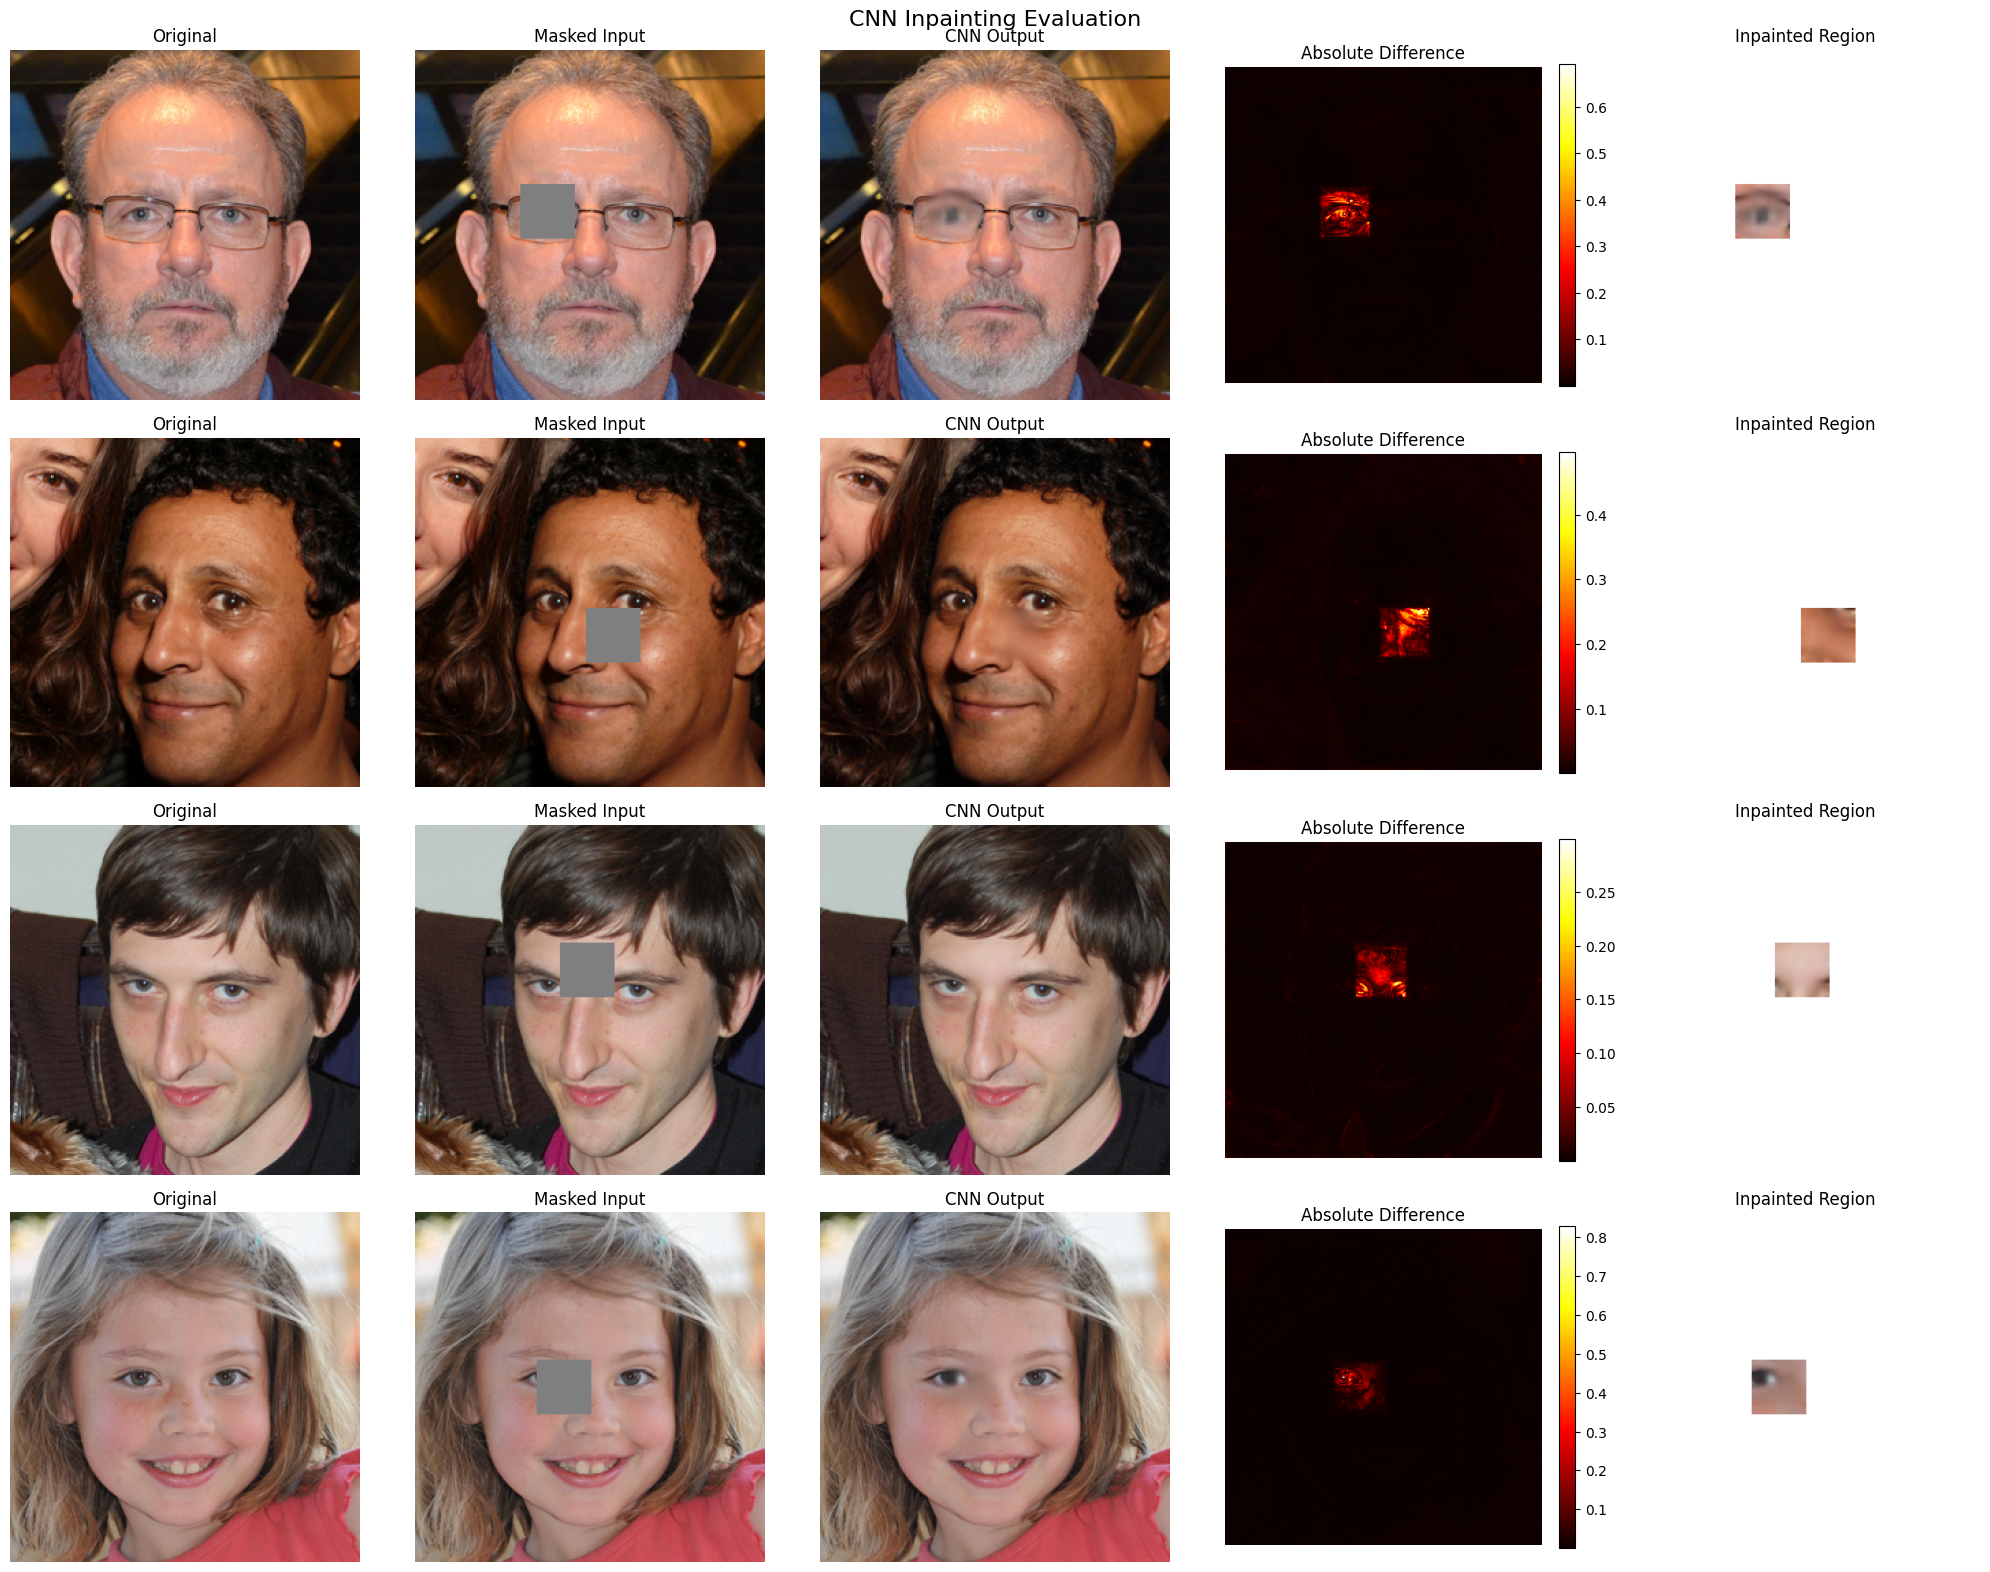


✅ Evaluation complete! Results saved to 'cnn_evaluation_results.txt'


In [12]:
# --- CNN Evaluation with Comprehensive Metrics ---
print("--- Evaluating CNN Model ---")

# Initialize the correct model
cnn_model = UNetSR(in_channels=4, out_channels=3)

# Load weights
state_dict = torch.load('/content/drive/MyDrive/ColabNotebooks/Vision/inpainting/final_cnn_model.pth', map_location=DEVICE)
if any(k.startswith('_orig_mod.') for k in state_dict.keys()):
    state_dict = {k.replace('_orig_mod.', ''): v for k, v in state_dict.items()}
cnn_model.load_state_dict(state_dict)

cnn_model.to(DEVICE)
cnn_model.eval()

# --- Initialize All Metrics ---
# 1. Basic metrics
psnr_metric = torchmetrics.PeakSignalNoiseRatio(data_range=1.0).to(DEVICE)
ssim_metric = torchmetrics.StructuralSimilarityIndexMeasure(data_range=1.0).to(DEVICE)

# 2. Perceptual metric (used in ResDiff paper)
lpips_metric = lpips.LPIPS(net='alex').to(DEVICE)  # Lower is better

# 3. Feature-based metric
fid_metric = FrechetInceptionDistance(feature=2048).to(DEVICE)

# Get evaluation batch
eval_dataloader = val_dataloader

# Collect metrics across multiple batches
all_psnr = []
all_ssim = []
all_lpips = []
all_mse = []
all_mae = []
all_masked_mse = []
all_masked_mae = []

print("Evaluating on multiple batches...")
for batch_idx, batch in enumerate(eval_dataloader):
    if batch_idx >= 10:  # Evaluate on 10 batches
        break

    original_images = batch.to(DEVICE)

    with torch.no_grad():
        masked_images, masks = create_mask(original_images)
        masks = masks.to(DEVICE)

        cnn_input = torch.cat((masked_images, masks[:, 0:1, :, :]), dim=1)
        cnn_reconstructions = cnn_model(cnn_input)

    # Denormalize from [-1, 1] to [0, 1]
    original_denorm = (original_images + 1) / 2
    recon_denorm = (cnn_reconstructions + 1) / 2

    # 1. PSNR and SSIM
    batch_psnr = psnr_metric(recon_denorm, original_denorm)
    batch_ssim = ssim_metric(recon_denorm, original_denorm)
    all_psnr.append(batch_psnr.item())
    all_ssim.append(batch_ssim.item())

    # 2. LPIPS (Perceptual loss)
    batch_lpips = lpips_metric(original_denorm * 2 - 1, recon_denorm * 2 - 1)  # LPIPS expects [-1, 1]
    all_lpips.append(batch_lpips.mean().item())

    # 3. MSE and MAE
    mse = torch.nn.functional.mse_loss(recon_denorm, original_denorm)
    mae = torch.nn.functional.l1_loss(recon_denorm, original_denorm)
    all_mse.append(mse.item())
    all_mae.append(mae.item())

    # 4. Masked region metrics
    mask_binary = (masks[:, 0:1, :, :] == 0).float()
    if mask_binary.sum() > 0:
        masked_mse = ((recon_denorm - original_denorm) ** 2 * mask_binary).sum() / mask_binary.sum()
        masked_mae = (torch.abs(recon_denorm - original_denorm) * mask_binary).sum() / mask_binary.sum()
        all_masked_mse.append(masked_mse.item())
        all_masked_mae.append(masked_mae.item())

    # Update FID metric
    # Convert to uint8 format expected by FID
    real_images_uint8 = (original_denorm * 255).to(torch.uint8)
    fake_images_uint8 = (recon_denorm * 255).to(torch.uint8)
    fid_metric.update(real_images_uint8, real=True)
    fid_metric.update(fake_images_uint8, real=False)

# Calculate FID
fid_score = fid_metric.compute()

# --- Print Comprehensive Results ---
print("\n" + "="*50)
print("CNN INPAINTING EVALUATION RESULTS")
print("="*50)

print("\n📊 RECONSTRUCTION METRICS:")
print(f"  PSNR:  {np.mean(all_psnr):.2f} ± {np.std(all_psnr):.2f} dB")
print(f"  SSIM:  {np.mean(all_ssim):.4f} ± {np.std(all_ssim):.4f}")
print(f"  MSE:   {np.mean(all_mse):.4f} ± {np.std(all_mse):.4f}")
print(f"  MAE:   {np.mean(all_mae):.4f} ± {np.std(all_mae):.4f}")

print("\n🎨 PERCEPTUAL METRICS:")
print(f"  LPIPS: {np.mean(all_lpips):.4f} ± {np.std(all_lpips):.4f} (lower is better)")
print(f"  FID:   {fid_score:.2f} (lower is better)")

print("\n🎯 MASKED REGION METRICS:")
print(f"  Masked MSE: {np.mean(all_masked_mse):.4f} ± {np.std(all_masked_mse):.4f}")
print(f"  Masked MAE: {np.mean(all_masked_mae):.4f} ± {np.std(all_masked_mae):.4f}")

# --- Frequency Domain Analysis ---
print("\n📈 FREQUENCY DOMAIN ANALYSIS:")
with torch.no_grad():
    # Get one batch for frequency analysis
    test_batch = next(iter(eval_dataloader)).to(DEVICE)
    masked_test, masks_test = create_mask(test_batch)
    masks_test = masks_test.to(DEVICE)

    cnn_input_test = torch.cat((masked_test, masks_test[:, 0:1, :, :]), dim=1)
    recon_test = cnn_model(cnn_input_test)

    # FFT Analysis
    fft_original = torch.fft.fft2(test_batch, dim=(-2, -1))
    fft_recon = torch.fft.fft2(recon_test, dim=(-2, -1))

    # Compare frequency magnitudes
    mag_original = torch.abs(fft_original).mean()
    mag_recon = torch.abs(fft_recon).mean()

    # High frequency analysis (outer regions of FFT)
    h, w = test_batch.shape[-2:]
    mask_high_freq = torch.ones_like(test_batch)
    mask_high_freq[:, :, h//4:3*h//4, w//4:3*w//4] = 0

    high_freq_original = (torch.abs(fft_original) * mask_high_freq).mean()
    high_freq_recon = (torch.abs(fft_recon) * mask_high_freq).mean()

    print(f"  Average Frequency Magnitude Ratio: {(mag_recon/mag_original):.3f}")
    print(f"  High-Frequency Recovery Ratio: {(high_freq_recon/high_freq_original):.3f}")

# --- Visualization with Difference Maps ---
num_to_show = 4
fig, axes = plt.subplots(num_to_show, 5, figsize=(20, num_to_show * 4))
fig.suptitle('CNN Inpainting Evaluation', fontsize=16)

# Get samples for visualization
vis_batch = next(iter(eval_dataloader)).to(DEVICE)
with torch.no_grad():
    vis_masked, vis_masks = create_mask(vis_batch[:num_to_show])
    vis_masks = vis_masks.to(DEVICE)
    vis_input = torch.cat((vis_masked, vis_masks[:, 0:1, :, :]), dim=1)
    vis_recon = cnn_model(vis_input)

for i in range(num_to_show):
    # Original
    axes[i, 0].imshow(tensor_to_image(vis_batch[i]))
    axes[i, 0].set_title("Original")
    axes[i, 0].axis('off')

    # Masked Input
    axes[i, 1].imshow(tensor_to_image(vis_masked[i]))
    axes[i, 1].set_title("Masked Input")
    axes[i, 1].axis('off')

    # CNN Reconstruction
    axes[i, 2].imshow(tensor_to_image(vis_recon[i]))
    axes[i, 2].set_title(f"CNN Output")
    axes[i, 2].axis('off')

    # Difference Map
    diff = torch.abs(vis_batch[i] - vis_recon[i]).mean(dim=0)
    im = axes[i, 3].imshow(diff.cpu().numpy(), cmap='hot')
    axes[i, 3].set_title("Absolute Difference")
    axes[i, 3].axis('off')
    plt.colorbar(im, ax=axes[i, 3], fraction=0.046)

    # Masked Region Only
    mask_vis = vis_masks[i, 0].cpu().numpy()
    masked_recon = tensor_to_image(vis_recon[i])
    masked_recon[mask_vis > 0.5] = 1  # Highlight unmasked regions
    axes[i, 4].imshow(masked_recon)
    axes[i, 4].set_title("Inpainted Region")
    axes[i, 4].axis('off')

plt.tight_layout()
plt.show()

# --- Save Results Summary ---
results_summary = f"""
CNN Inpainting Evaluation Results
=================================
PSNR: {np.mean(all_psnr):.2f} ± {np.std(all_psnr):.2f} dB
SSIM: {np.mean(all_ssim):.4f} ± {np.std(all_ssim):.4f}
LPIPS: {np.mean(all_lpips):.4f} ± {np.std(all_lpips):.4f}
FID: {fid_score:.2f}
Masked MSE: {np.mean(all_masked_mse):.4f}
Masked MAE: {np.mean(all_masked_mae):.4f}
"""

with open('cnn_evaluation_results.txt', 'w') as f:
    f.write(results_summary)

print("\n✅ Evaluation complete! Results saved to 'cnn_evaluation_results.txt'")